In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Load the dataset from the given URL
dataset_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(dataset_url)

In [4]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
print(data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Handling Missing Values

In [7]:
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data.drop(columns=['Cabin'], inplace=True)  # Dropping 'Cabin' due to many missing values

C:\Users\420317\AppData\Local\Temp\ipykernel_14184\3369368747.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\420317\AppData\Local\Temp\ipykernel_14184\3369368747.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


#### Encoding Categorical Data

In [8]:
label_enc = LabelEncoder()
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'])

C:\Users\420317\AppData\Local\Temp\ipykernel_14184\1366425573.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rates[feature] = data.groupby(feature)['Survived'].mean()


<Figure size 1200x600 with 0 Axes>

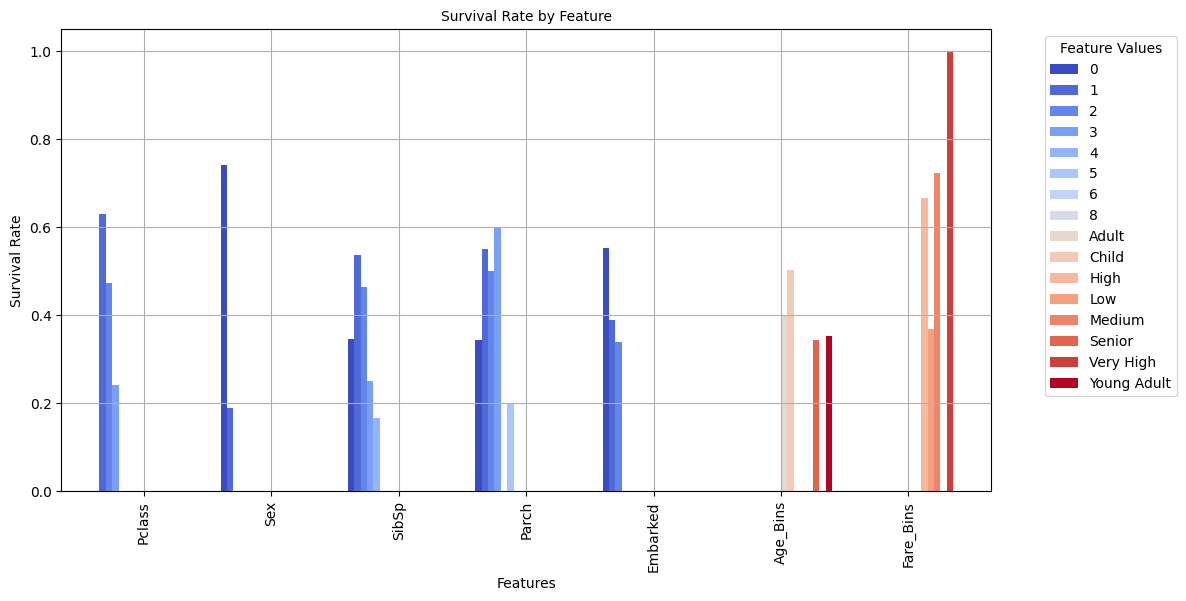

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency


label_enc = LabelEncoder()
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'].astype(str))  # Convert to string to handle NaNs


data['Age_Bins'] = pd.cut(data['Age'], bins=[0, 18, 35, 50, 80], labels=['Child', 'Young Adult', 'Adult', 'Senior'])
data['Fare_Bins'] = pd.cut(data['Fare'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Age_Bins', 'Fare_Bins']

survival_rates = {}
for feature in features:
    survival_rates[feature] = data.groupby(feature)['Survived'].mean()

survival_data = pd.DataFrame(survival_rates).T 

# Plot the survival rates
plt.figure(figsize=(12, 6))
survival_data.plot(kind='bar', figsize=(12, 6), colormap='coolwarm', width=0.8)

# Formatting
plt.title("Survival Rate by Feature", fontsize=10)
plt.ylabel("Survival Rate", fontsize=10)
plt.xlabel("Features", fontsize=10)
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.legend(title="Feature Values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()



#### Most Influencing Features on Survival

In [10]:
corr = data[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr()['Survived'].abs().sort_values(ascending=False)

chi2_results = {}
for feature in ['Sex', 'Embarked']:
    contingency_table = pd.crosstab(data[feature], data['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[feature] = chi2

feature_importance = pd.concat([pd.Series(chi2_results), corr])
feature_importance = (feature_importance / feature_importance.sum()) * 100  
feature_importance = feature_importance.sort_values(ascending=False)  
values = feature_importance.round(2) # Round to 2 decimal places & add '%' sign

pd.DataFrame(values,columns=['%'])


,%
Sex,90.38
Embarked,9.00
Survived,0.35
Pclass,0.12
Fare,0.09
Parch,0.03
Age,0.02
SibSp,0.01


In [11]:
# Selecting Features and find_values Variable
features = ['Sex','Embarked','Pclass','Fare','Parch','Age','SibSp']
find_values = 'Survived'
X = data[features]
y = data[find_values]

##### # Feature Scaling

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(pd.DataFrame(X_train, columns=features).head())

        Sex  Embarked    Pclass      Fare     Parch       Age     SibSp
0  0.737695  0.585954 -1.566107 -0.074583 -0.473674  1.240235 -0.474545
1  0.737695  0.585954 -0.369365 -0.386671 -0.473674 -0.488887 -0.474545
2  0.737695  0.585954  0.827377 -0.488854 -0.473674  0.202762 -0.474545
3  0.737695  0.585954  0.827377 -0.490280 -0.473674 -0.258337  0.432793
4 -1.355574  0.585954  0.827377 -0.018709  2.008933 -1.795334  3.154809



#### Build a deeper neural network

In [14]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    
    layers.Dense(128, activation='relu'),
    BatchNormalization(),   # Normalizes layer inputs           
    
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3), # Prevents overfitting
    
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    layers.Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    layers.Dense(8, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

optimizer = Adam(learning_rate=0.001)  

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test))


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5464 - loss: 0.7328 - val_accuracy: 0.7039 - val_loss: 0.6628
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6724 - loss: 0.6029 - val_accuracy: 0.7207 - val_loss: 0.6271
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7478 - loss: 0.5322 - val_accuracy: 0.7598 - val_loss: 0.5906
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7515 - loss: 0.5283 - val_accuracy: 0.7933 - val_loss: 0.5618
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7799 - loss: 0.5072 - val_accuracy: 0.8156 - val_loss: 0.5359
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7945 - loss: 0.5004 - val_accuracy: 0.8156 - val_loss: 0.5068
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7879 - loss: 0.4990 - val_accuracy: 0.8268 - val_loss: 0.4834
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8110 - loss: 0.4582 - val_accuracy: 0.8212 - 

#### Evaluate the Model

In [17]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.8156
Precision: 0.8254
Recall: 0.7027
F1-score: 0.7591


####  Plot Confusion Matrix

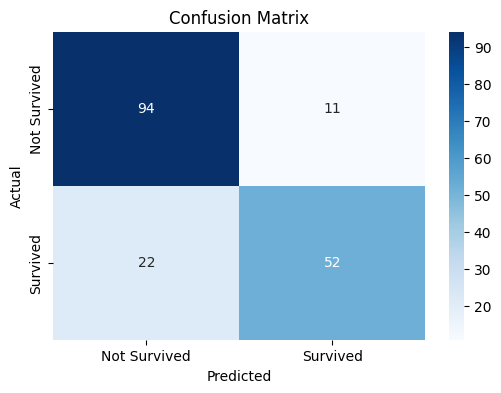

In [18]:

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Plot training & validation accuracy values

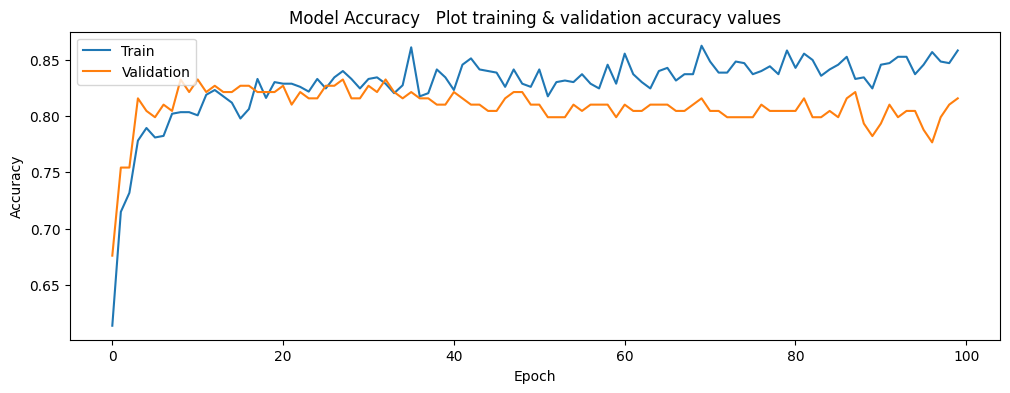

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy   Plot training & validation accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Plot training & validation loss values

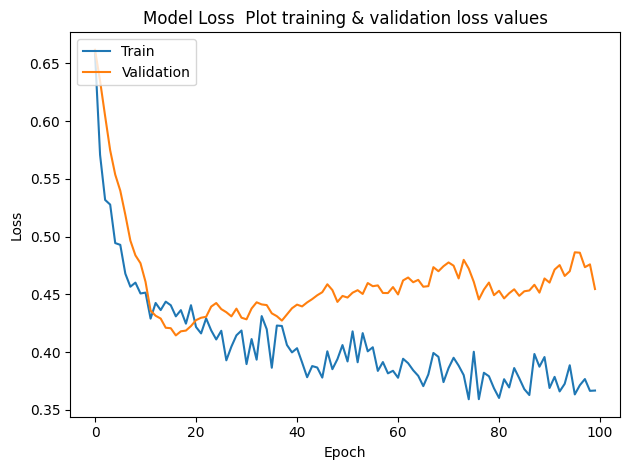

In [20]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss  Plot training & validation loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

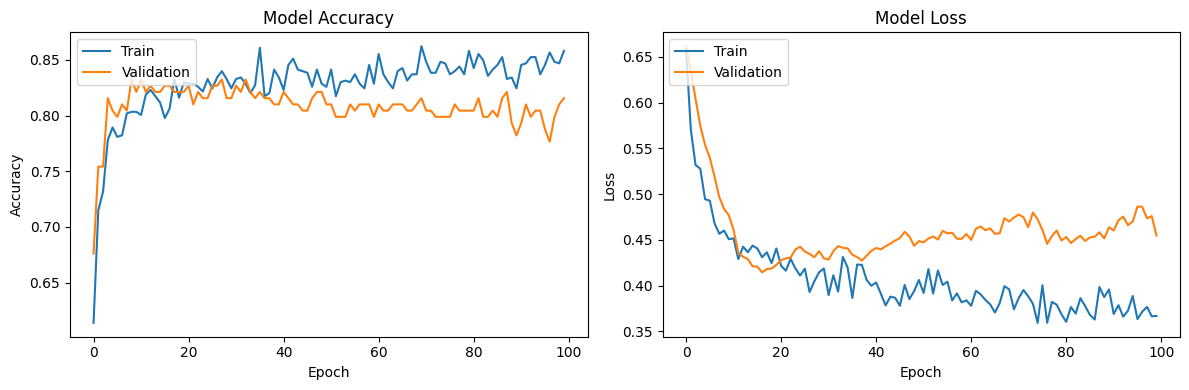

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


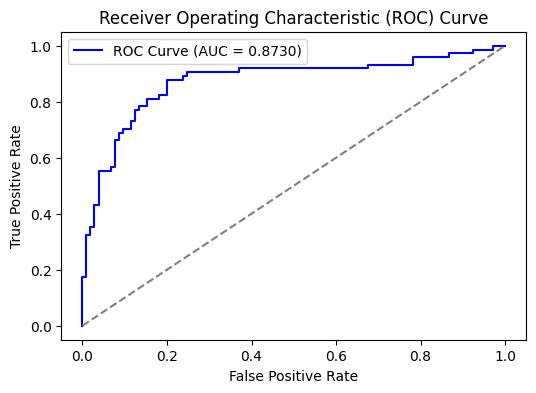

In [16]:
# ROC Curve
y_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### After Data Balanced using smote

In [17]:
from collections import Counter
from imblearn.over_sampling import SMOTE
sm=SMOTE()
x_data,y_data=sm.fit_resample(X,y)
print(Counter(y_data))

Counter({0: 549, 1: 549})


In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,random_state=42,test_size=0.15)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((933, 7), (165, 7), (933,), (165,))

In [19]:
# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [20]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    
    layers.Dense(128, activation='relu'),
    BatchNormalization(),   # Normalizes layer inputs           
    
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3), # Prevents overfitting
    
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    layers.Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    layers.Dense(8, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])



In [21]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
ROP=ReduceLROnPlateau(MONITOR='val_loss',factor=0.5,patience=5)

In [23]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5181 - loss: 0.8331 - val_accuracy: 0.5829 - val_loss: 0.6865
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6330 - loss: 0.6563 - val_accuracy: 0.6203 - val_loss: 0.6743
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7392 - loss: 0.5351 - val_accuracy: 0.6150 - val_loss: 0.6606
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7575 - loss: 0.5512 - val_accuracy: 0.6471 - val_loss: 0.6369
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7727 - loss: 0.4972 - val_accuracy: 0.6791 - val_loss: 0.6128
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7679 - loss: 0.5023 - val_accuracy: 0.7005 - val_loss: 0.5924
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8042 - loss: 0.4505 - val_accuracy: 0.7059 - val_loss: 0.5747
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.4547 - val_accuracy: 0.7219 - val_loss

In [24]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.3730 
Test Accuracy: 0.8787878751754761


In [25]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.8787878787878788
Precision: 0.9436619718309859
Recall: 0.8072289156626506
F1 Score: 0.8701298701298701


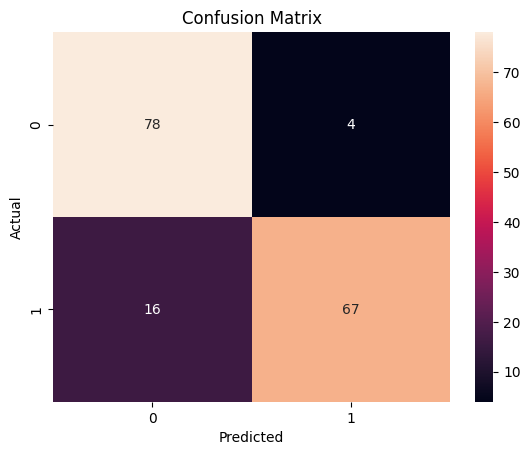

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

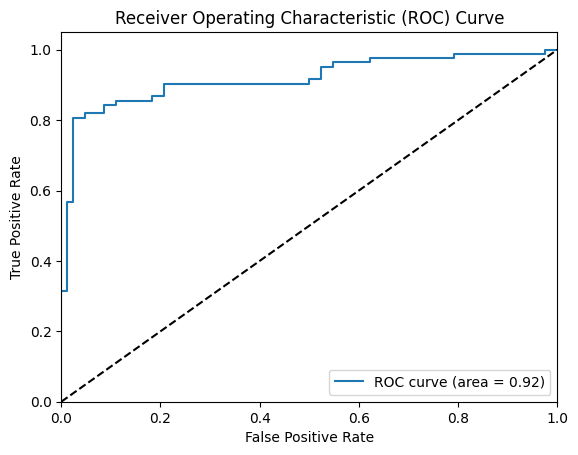

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test.values.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0 ,1.0])
plt.ylim([0.0 ,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()